# Navier-Stokes Equation
## A 3 Dimensional Numerical Experiment of FNOs

This notebook wals through the Fourier Neural Operator for a 3D problem such as the Navier-Stokes equation discussed in Section 5.3 in the [Fourier Neural Operator for
Parametric Partial Differential Equations](https://arxiv.org/pdf/2010.08895.pdf),
which takes the 2D spatial + 1D temporal equation directly as a 3D problem

In [27]:
import pprint
from typing import Any, Callable, Generic, NamedTuple, Optional, Tuple, TypeVar

import yaml
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer

from torch.nn.functional import mse_loss
import torch

from neuralop import count_params
from neuralop.datasets import load_navier_stokes_temporal_pt
from neuralop.layers import SpectralConv3d
from neuralop.models import FNO3d
from neuralop.training import LpLoss

torch.manual_seed(0)
np.random.seed(0)

In [2]:
#################################################
# Utilities
#################################################
device = torch.device(
    'cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda


In [3]:
################################################################
# fourier layer
################################################################
print(
"""
The overall network. It contains 4 layers of the Fourier layer.
1. Lift the input to the desire channel dimension by self.fc0 .
2. 4 layers of the integral operators u' = (W + K)(u).
    W defined by self.w; K defined by self.conv .
3. Project from the channel space to the output space by self.fc1 and self.fc2 .

input: the solution of the first 10 timesteps + 3 locations
  (u(1, x, y), ..., u(10, x, y),  x, y, t).
  It's a constant function in time, except for the last index.
input shape: (batchsize, x=64, y=64, t=40, c=13)
output: the solution of the next 40 timesteps
output shape: (batchsize, x=64, y=64, t=40, c=1)
"""
)


The overall network. It contains 4 layers of the Fourier layer.
1. Lift the input to the desire channel dimension by self.fc0 .
2. 4 layers of the integral operators u' = (W + K)(u).
    W defined by self.w; K defined by self.conv .
3. Project from the channel space to the output space by self.fc1 and self.fc2 .

input: the solution of the first 10 timesteps + 3 locations
  (u(1, x, y), ..., u(10, x, y),  x, y, t).
  It's a constant function in time, except for the last index.
input shape: (batchsize, x=64, y=64, t=40, c=13)
output: the solution of the next 40 timesteps
output shape: (batchsize, x=64, y=64, t=40, c=1)



In [4]:
class Config(NamedTuple):
    data_path: str
    n_train: int
    n_test: int
    train_batch_size: int
    test_batch_size: int
    learning_rate: float
    epochs: int
    iterations: int
    modes: int
    width: int
    subsampling_rate: int
    s: int
    history_length: int
    future_duration: int
        
    @staticmethod
    def from_yaml(config_path: str):
        with open(config_path, 'r') as f:
            cfg = yaml.load(f)

        config = Config(
            data_path=cfg['data_path'],
            n_train=cfg['n_train'],
            n_test=cfg['n_test'],
            train_batch_size=cfg['train_batch_size'],
            test_batch_size=cfg['test_batch_size'],
            learning_rate=cfg['learning_rate'],
            epochs=cfg['epochs'],
            iterations=cfg['iterations'],
            modes=cfg['modes'],
            width=cfg['width'],
            subsampling_rate=cfg['subsampling_rate'],
            s=cfg['s'],
            history_length=cfg['history_length'],
            future_duration=cfg['future_duration'],
        )        
        return config


config = Config.from_yaml('fourier_3d_V1e-3.yaml')

In [5]:
################################################################
# load data and data normalization
################################################################

train_loader, test_loader, output_encoder = load_navier_stokes_temporal_pt(
    config.data_path,
    config.n_train,
    config.n_test,
    config.history_length,
    config.future_duration,
    config.train_batch_size,
    config.test_batch_size,
    future_encoding=True,
)

In [6]:
model = FNO3d(
    config.modes,  # modes_width
    config.modes,  # modes_height
    config.modes,  # mode_duration (i.e. in time)
    config.width,  # width of all hidden layers
    # input channels are 13: the solution of the previous 10 timesteps + 2 spatial location + 1 temporal encodings
    # i.e: (u(t-9, x, y), ..., u(t-1, x, y), u(t, x, y),  x, y, t)
    in_channels=config.history_length + 3,
    # output channel is 1: (u(t, x, y))
    # However, because of the redundancy of the input tensor (with repeated dimension 1)
    # we expect the operator to learn to put each successive timestep in successive slices
    out_channels=1,
    n_layers=4,
    domain_padding=0.1,
    # domain_padding=None,
    domain_padding_mode='one-sided',
    use_mlp=True,
).cuda()
print(f"Model parameter count: {count_params(model):,d}")

Model parameter count: 828,593


In [7]:
################################################################
# training and evaluation
################################################################
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=1e-4
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=config.iterations
)
lp_loss = LpLoss()  # By default, does not do size averaging
output_encoder.cuda()

header_strings = (
    'Epoch',
    'Duration',
    'Training MSE',
    'Training L2',
    'Testing L2',
)
HEADER = ' | '.join(header_strings)
for ep in range(config.epochs):
    model.train()
    t1 = default_timer()
    train_mse = 0
    train_l2 = 0
    for train_data in train_loader:
        x, y = train_data['x'].to(device), train_data['y'].to(device)

        optimizer.zero_grad()
        # Squeeze singleton channel for loss computation:
        out = model(x).squeeze(1)
        mse = mse_loss(out, y, reduction='mean')
        # mse.backward()

        y = output_encoder.decode(y)
        out = output_encoder.decode(out)
        l2 = lp_loss(out.view(config.train_batch_size, -1),
                     y.view(config.train_batch_size, -1))
        l2.backward()

        optimizer.step()
        scheduler.step()
        train_mse += mse.item()
        train_l2 += l2.item()

    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for test_data in test_loader:
            x = test_data['x'].to(device)
            y = test_data['y'].to(device)

            out = model(x).squeeze(1)
            out = output_encoder.decode(out)
            test_l2 += lp_loss(out.view(config.test_batch_size, -1),
                               y.view(config.test_batch_size, -1)).item()

    train_mse /= len(train_loader)
    train_l2 /= config.n_train
    test_l2 /= config.n_test

    t2 = default_timer()
    if ep % 20 == 0:
        print(HEADER)
    row = ' | '.join(
        [f'{ep:{len(header_strings[0])}d}', f'{t2 - t1:{len(header_strings[1])}.3f}'] + 
        [f'{x:{len(s)}.6f}' for s, x
         in zip(header_strings[2:], (train_mse,
                                     train_l2,
                                     test_l2))])
    print(row)

Padding inputs of resolution=torch.Size([40, 64, 64]) with padding=[4, 6, 6], one-sided
Epoch | Duration | Training MSE | Training L2 | Testing L2
    0 |   81.792 |     0.321449 |    0.536687 |   0.321302
    1 |   82.003 |     0.089479 |    0.294265 |   0.272689
    2 |   82.230 |     0.065225 |    0.250540 |   0.226691
    3 |   82.513 |     0.043056 |    0.203935 |   0.197069
    4 |   82.465 |     0.031297 |    0.173469 |   0.169897
    5 |   82.492 |     0.023767 |    0.150788 |   0.147001
    6 |   82.458 |     0.019818 |    0.137552 |   0.135650
    7 |   82.489 |     0.016200 |    0.124238 |   0.123170
    8 |   82.535 |     0.013260 |    0.112333 |   0.111988
    9 |   82.890 |     0.011591 |    0.105038 |   0.106765
   10 |   82.840 |     0.009967 |    0.097734 |   0.101159
   11 |   82.826 |     0.008748 |    0.091568 |   0.092685
   12 |   82.815 |     0.007860 |    0.086614 |   0.086730
   13 |   82.842 |     0.007025 |    0.081921 |   0.089116
   14 |   82.839 |     0.00

  132 |   82.804 |     0.000705 |    0.025993 |   0.028958
  133 |   82.829 |     0.000704 |    0.025969 |   0.028948
  134 |   82.810 |     0.000696 |    0.025835 |   0.028556
  135 |   82.835 |     0.000705 |    0.025984 |   0.029653
  136 |   82.841 |     0.000684 |    0.025603 |   0.028184
  137 |   82.854 |     0.000753 |    0.026877 |   0.029248
  138 |   82.836 |     0.000706 |    0.026020 |   0.028691
  139 |   82.833 |     0.000701 |    0.025912 |   0.028405
Epoch | Duration | Training MSE | Training L2 | Testing L2
  140 |   82.839 |     0.000683 |    0.025592 |   0.027580
  141 |   82.856 |     0.000705 |    0.025958 |   0.028378
  142 |   82.841 |     0.000676 |    0.025471 |   0.027130
  143 |   82.812 |     0.000651 |    0.024940 |   0.026971
  144 |   82.845 |     0.000651 |    0.024979 |   0.028781
  145 |   82.833 |     0.000678 |    0.025478 |   0.027790
  146 |   82.856 |     0.000653 |    0.025007 |   0.028607
  147 |   82.875 |     0.000653 |    0.025008 |   0.0275

  264 |   82.809 |     0.000418 |    0.019909 |   0.022979
  265 |   82.794 |     0.000419 |    0.019927 |   0.023018
  266 |   82.834 |     0.000419 |    0.019927 |   0.023002
  267 |   82.813 |     0.000418 |    0.019927 |   0.023032
  268 |   82.829 |     0.000420 |    0.019955 |   0.023030
  269 |   82.782 |     0.000421 |    0.019987 |   0.022968
  270 |   82.833 |     0.000421 |    0.019982 |   0.023108
  271 |   82.819 |     0.000422 |    0.020005 |   0.023069
  272 |   82.841 |     0.000420 |    0.019974 |   0.022967
  273 |   82.867 |     0.000422 |    0.020004 |   0.023095
  274 |   82.839 |     0.000422 |    0.020021 |   0.022974
  275 |   82.801 |     0.000422 |    0.020014 |   0.023010
  276 |   82.852 |     0.000422 |    0.020017 |   0.022998
  277 |   82.818 |     0.000423 |    0.020026 |   0.023078
  278 |   82.795 |     0.000423 |    0.020040 |   0.023127
  279 |   82.844 |     0.000425 |    0.020094 |   0.023106
Epoch | Duration | Training MSE | Training L2 | Testing 

  397 |   82.882 |     0.000617 |    0.024382 |   0.028227
  398 |   82.856 |     0.000612 |    0.024221 |   0.024838
  399 |   82.858 |     0.000551 |    0.023010 |   0.025482
Epoch | Duration | Training MSE | Training L2 | Testing L2
  400 |   82.822 |     0.000574 |    0.023471 |   0.024813
  401 |   82.843 |     0.000596 |    0.023906 |   0.025899
  402 |   82.918 |     0.000580 |    0.023610 |   0.025324
  403 |   82.870 |     0.000579 |    0.023561 |   0.027478
  404 |   82.819 |     0.000588 |    0.023799 |   0.028311
  405 |   82.856 |     0.000674 |    0.025345 |   0.027582
  406 |   82.820 |     0.000593 |    0.023831 |   0.027250
  407 |   82.858 |     0.000645 |    0.024881 |   0.027310
  408 |   82.918 |     0.000607 |    0.024149 |   0.027257
  409 |   82.818 |     0.000647 |    0.024914 |   0.024833
  410 |   82.812 |     0.000596 |    0.023921 |   0.023975
  411 |   82.863 |     0.000604 |    0.024079 |   0.026042
  412 |   82.822 |     0.000648 |    0.024901 |   0.0262

## Visualization

Visualize the error in the trained model against a subsample of testing data points. Also visualize the error (squared to be non-negative).

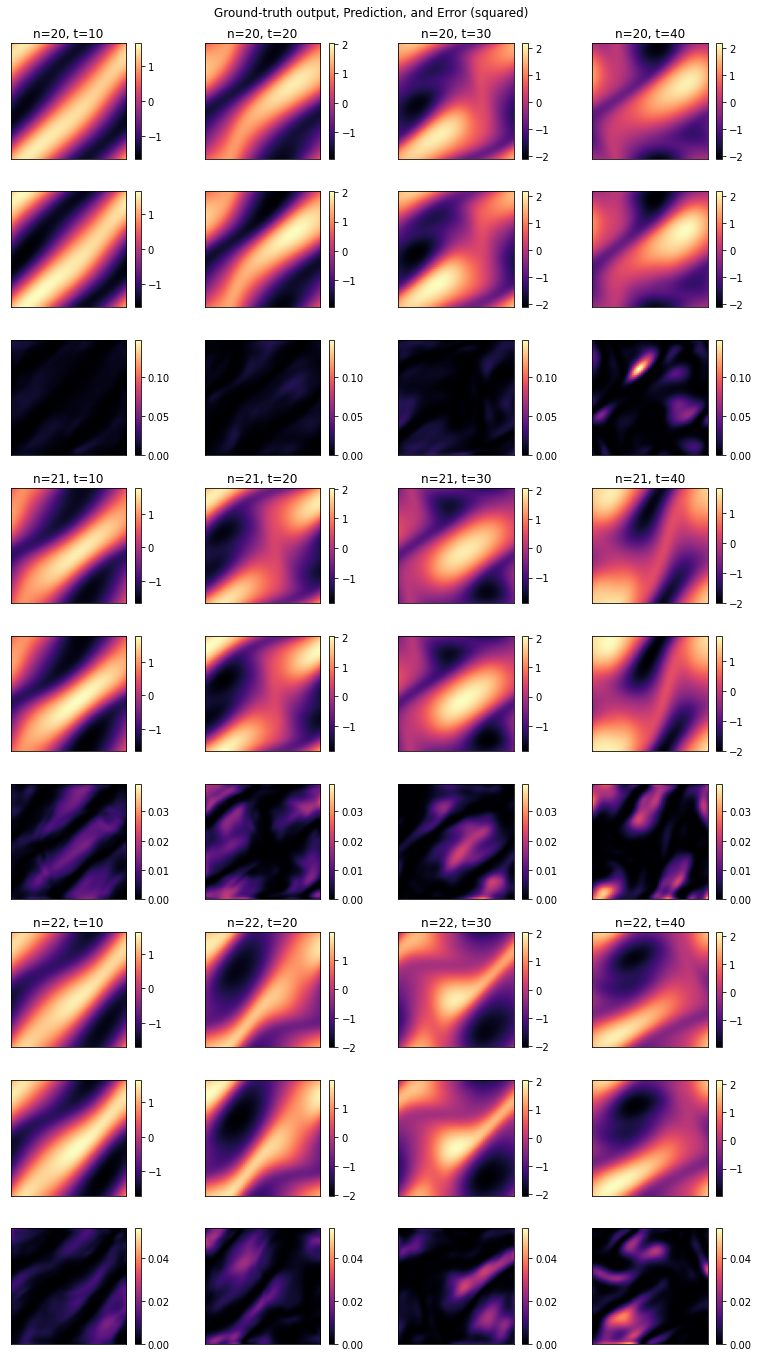

In [40]:
test_samples = test_loader.dataset
n_samples = 3
n_rows = 3
n_cols = 4
t_step = 10

def sample_largest_error(error: torch.Tensor) -> int:
    """
    Given a batch out error tensors, pick the batch element
    with the highest maximum error.
    """
    m = [error[i].max() for i in range(error.shape[0])]
    mi = max(enumerate(m), key=lambda x: x[1])
    return mi[0]

fig = plt.figure(figsize=(11,  # width (inches)
                          19))  # height (inches)
# sample = 0
for sample in range(n_samples):
    idx = 20 + sample
    test_data = test_samples[idx]
    x = test_data['x'].to(device)
    y = test_data['y'].to(device)
    out = model(x.unsqueeze(0)).squeeze(1).squeeze(0)
    error = (out - y).square()
    
    vmin = [
        min(y[i].min(), out[i].min())
        for i in range(9, 40, t_step)
    ] 
    vmax = [
        max(y[i].max(), out[i].max())
        for i in range(9, 40, t_step)
    ] 

    # Ground truth:
    r = sample * n_rows
    for c in range(n_cols):
        t = (c + 1) * t_step - 1
        ax = fig.add_subplot(n_rows * n_samples, n_cols, r * n_cols + c + 1)
        im = ax.imshow(y[t].cpu(),
                       cmap='magma', 
                       vmin=vmin[c], 
                       vmax=vmax[c])
        ax.set_title(f'n={idx}, t={t + 1}')
        plt.xticks([], [])
        plt.yticks([], [])
        fig.colorbar(im, ax=ax)

    # Model prediction:
    r = sample * n_rows + 1
    for c in range(n_cols):
        t = (c + 1) * t_step - 1
        ax = fig.add_subplot(n_rows * n_samples, n_cols, r * n_cols + c + 1)
        im = ax.imshow(out[t].detach().cpu(),
                       cmap='magma', 
                       vmin=vmin[c], 
                       vmax=vmax[c])
        plt.xticks([], [])
        plt.yticks([], [])
        fig.colorbar(im, ax=ax)

    # Error:
    r = sample * n_rows + 2
    for c in range(n_cols):
        t = (c + 1) * t_step - 1   
        ax = fig.add_subplot(n_rows * n_samples, n_cols, r * n_cols + c + 1)
        im = ax.imshow(error[t].detach().cpu(),
                       cmap='magma',
                       vmin=error.min(),
                       vmax=error.max())
        # print(f'{error[t].min():7.5f} <= error[t] <= {error[t].max():7.5f}')
        plt.xticks([], [])
        plt.yticks([], [])
        fig.colorbar(im, ax=ax)

fig.suptitle('Ground-truth output, Prediction, and Error (squared)', y=0.99)
plt.tight_layout()
fig.show()